## Project Submission

Please fill out:
* Student name: Daniel Bradley and Monica Haderthauer
* Student pace: full time
* Scheduled project review date/time: 03/31/2022
* Instructor name: Praveen Gowtham
* Blog post URL: https://github.com/DanlBradley/Phase2Project


In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

## Initial inspection and cleaning
- Clean up DataFrame, drop NaN entries if there is sufficient data, and look for NaN entries that go under a placeholder name
- Split DataFrame into numerics and categorical variables
- Basic feature engineering such as 'price / sqfoot' column and 'renovated vs. not renovated' column

In [3]:
#Create housing dataframe
df = pd.read_csv('data/kc_house_data.csv')
#Clean up NaNs
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan)
df.drop(columns = 'sqft_lot15')
df = df.dropna()


#Convert date string to datetime
df['date'] = pd.to_datetime(df['date'])


#Convert sqft_basement to a float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))


#Add categorical column "renovated" vs "not renovated"
df['renovated_status'] = df['yr_renovated'].apply(lambda x: 'NO' if x == 0 else 'YES')


#Add a price / sqfoot column
df['price_per_sqfoot'] = df['price'] / df['sqft_above']

In [4]:
#Create dataframe for just numerics
df_numerics = df.select_dtypes(include = np.number, exclude = object)

#Select a target metric to compare other columns to
target_metric = 'price_per_sqfoot'

In [5]:
#Create a categorical dataframe
df_cat = df[['waterfront','view','condition','grade','renovated_status']]

In [6]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
y = df_numerics[target_metric]
x = sm.add_constant(df_numerics.drop(columns=[target_metric,'id','yr_renovated','zipcode','sqft_lot15']))
model = sm.OLS(y,x).fit()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


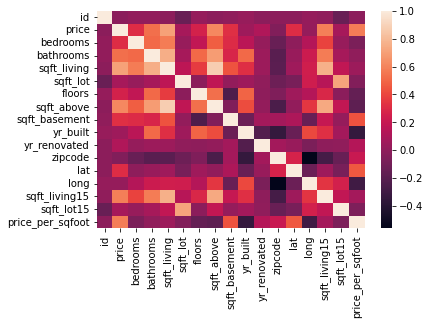

In [7]:
import seaborn as sns

#Correlation matrix
Var_Corr = df_numerics.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

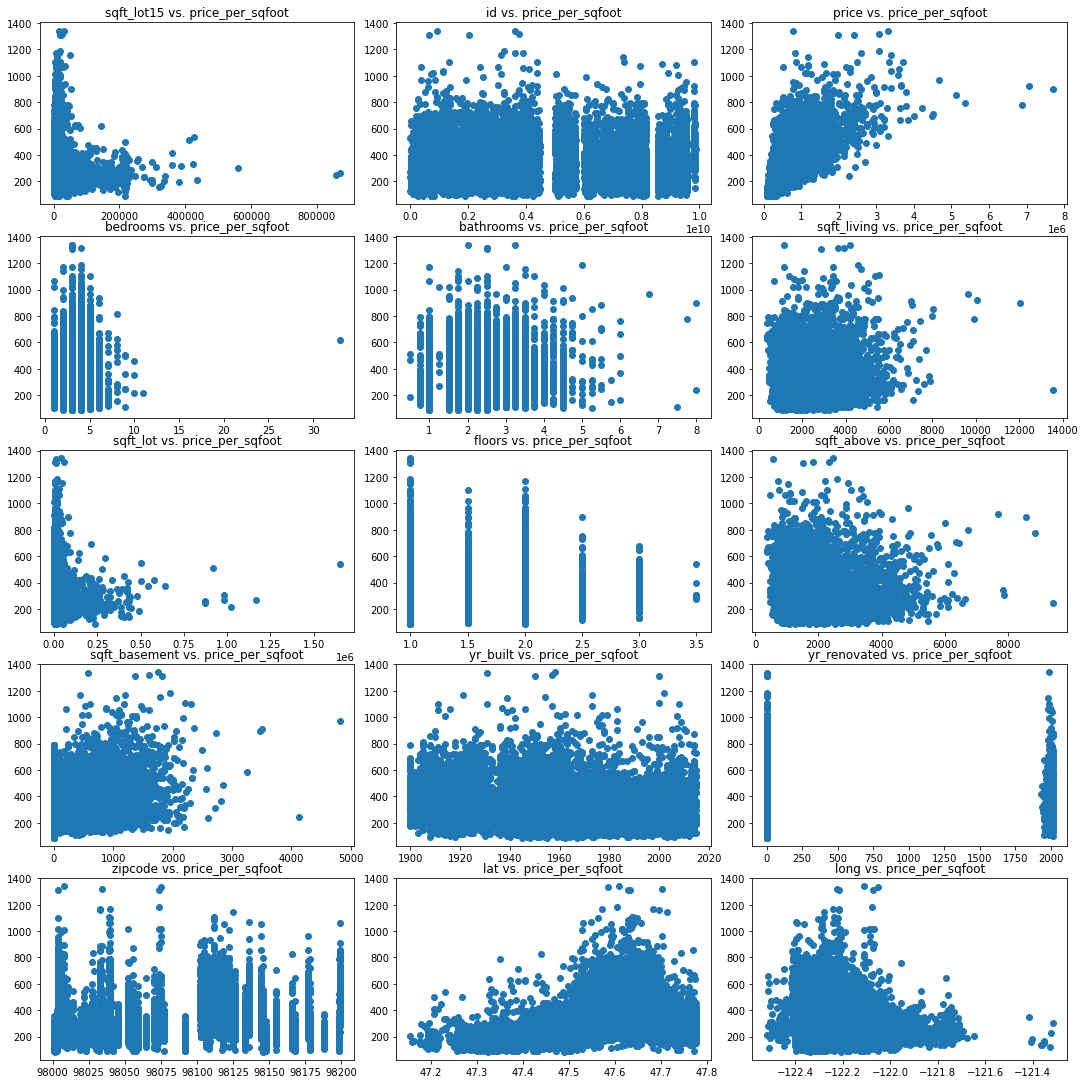

In [8]:
fig, axs = plt.subplots(5,3)


fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = df_numerics.drop(columns=target_metric)
dependant = df_numerics[target_metric]
column_num = 0

for i in range(5):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], target_metric))
        column_num += 1

In [9]:
import folium
df_renovated = df_numerics.loc[df_numerics['yr_renovated'] != 0]
lat = df_renovated['lat']
long = df_renovated['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=13)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map


In [10]:
df_numerics.loc[df_numerics['lat'] == 47.6036]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqfoot
1333,8961990160,567500.0,3,2.5,2080,4556,2.0,2080,0.0,1999,0.0,98074,47.6036,-122.014,1530,5606,272.836538
12830,9826701345,498000.0,3,2.5,1620,2640,2.0,1620,0.0,1900,1993.0,98122,47.6036,-122.305,1370,3840,307.407407


## Combining seattle AirBNB data with seattle housing data 
- Determine a predictive model for homes doing well in airbnb vs. the housing data
- Then make inferences about what to look for in a home when buying as an AirBNB investment

In [21]:
bnb_listings = pd.read_csv('data/earnings_data.csv')
bnb_listings['longitude'] = round(bnb_listings['longitude'],3)
bnb_listings['long'] = round(bnb_listings['longitude'],3)
bnb_listings['latitude'] = round(bnb_listings['latitude'],3)
bnb_listings['lat'] = round(bnb_listings['latitude'],3)

In [24]:
merged = df.merge(bnb_listings, how = 'inner', on = ['long','lat'])

In [25]:
lat = merged['lat']
long = merged['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=12)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;

In [26]:
print(list(merged.columns))

['id_x', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode_x', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated_status', 'price_per_sqfoot', 'Unnamed: 0', 'id_y', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode_y', 'market

In [27]:
merged_numerics = merged.select_dtypes(include = np.number, exclude = object)
merged_numerics = merged_numerics.drop(columns = ['square_feet','license'])
merged_numerics = merged_numerics.dropna()
merged_numerics.shape

(68, 41)

In [33]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
bnb_metric = 'avg_earnings'
y = merged_numerics[bnb_metric]
x = sm.add_constant(merged_numerics.drop(columns=[bnb_metric]))
model = sm.OLS(y,x).fit()
model.summary()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_earnings   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     4.985
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           4.37e-06
Time:                        18:26:19   Log-Likelihood:                -329.24
No. Observations:                  68   AIC:                             724.5
Df Residuals:                      35   BIC:                             797.7
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
id_x                           -2.416e-10    2.8e-09     -0.086      0.932   -5.92e-09    5.44e-09
price                           6.145e-05   8.25e-05      0.745      0.461      -0.000       0.000
bedrooms                           2.8589      8.297      0.345      0.732     -13.984      19.702
bathrooms                          1.3372     19.759      0.068      0.946     -38.776      41.451
sqft_living                       -0.0097      0.063     -0.155      0.878      -0.137       0.118
sqft_lot                           0.0053      0.003      1.757      0.088      -0.001       0.012
floors                           -29.7213     22.379     -1.328      0.193     -75.154      15.711
sqft_above                        -0.0040      0.060     -0.067      0.947      -0.125       0.117
sqft_basement                      0.0094      0.059      0.159      0.874      -0.111       0.130
yr_built                          -0.0225      0.376     -0.060      0.953      -0.786       0.741
yr_renovated                       0.0143      0.015      0.986      0.331      -0.015       0.044
zipcode_x                         -0.6112      1.047     -0.584      0.563      -2.736       1.514
lat                               28.9784    116.042      0.250      0.804    -206.600     264.557
long                              -1.6950    119.703     -0.014      0.989    -244.704     241.314
sqft_living15                     -0.0114      0.022     -0.506      0.616      -0.057       0.034
sqft_lot15                        -0.0105      0.006     -1.882      0.068      -0.022       0.001
price_per_sqfoot                  -0.0621      0.141     -0.442      0.661      -0.348       0.223
Unnamed: 0                        -0.0021      0.008     -0.262      0.795      -0.019       0.014
id_y                            7.932e-07   3.91e-06      0.203      0.841   -7.15e-06    8.74e-06
scrape_id                       2.783e-09   5.31e-09      0.524      0.603   -7.99e-09    1.36e-08
host_listings_count                3.3103      7.958      0.416      0.680     -12.845      19.465
host_total_listings_count          3.3103      7.958      0.416      0.680     -12.845      19.465
latitude                          28.9784    116.042      0.250      0.804    -206.600     264.557
longitude                         -1.6950    119.702     -0.014      0.989    -244.704     241.314
accommodates                      23.7572      6.119      3.882      0.000      11.334      36.180
guests_included                   -2.8723      6.227     -0.461      0.647     -15.513       9.768
minimum_nights                   -10.0291      9.370     -1.070      0.292     -29.051       8.992
maximum_nights                     0.0007      0.017      0.041      0.967      -0.034       0.036
availability_9

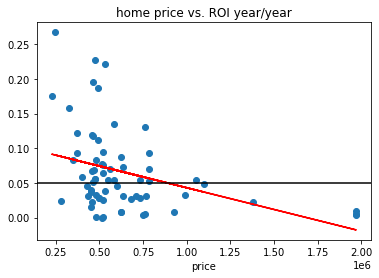

In [56]:
#Parameterized cell to let you scatter two variables from merged_numerics

fig, ax = plt.subplots()
x = merged_numerics['price']
y = (merged_numerics['avg_earnings'] * 365) / merged_numerics['price']
m,b = np.polyfit(x = x, y = y, deg = 1)
plt.scatter(x,y)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('home {} vs. ROI year/year'.format(x.name))
plt.plot(x,x*m+b, c= 'r')
plt.axhline(.05, c = 'black');


In [17]:
#Clean up this gigantic DataFrame by dropping irrelevant columns
#merged_numerics.drop(columns = [])

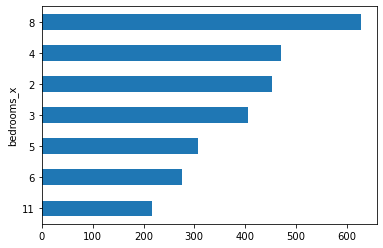

In [18]:
#This cell is just to take a look at some of the categorical columns vs. sales
merged.groupby('bedrooms_x')[target_metric].mean().sort_values().plot.barh();

In [19]:
#Import csv from other jupyter notebook file (airbnb.ipynb)
